In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
import itertools
import operator
import numpy as np
import math
%matplotlib inline 
plt.ion()
#plt.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

from time import time
import datetime

import sys
sys.path.append('../simulations/')
from grid_manager import *
from habitat_analysis import *
from hdf5_reader import *

In [2]:
def perm_wall_sim(grid_shape = (30,60), Q=1, A=0.5, ww=3., wp=0.5, cw=[3.,3.], cp=[0.35,0.7], ia=0.):
    # 1. initialize landscape
    n_rows,n_cols = grid_shape
    N = n_rows*n_cols
    qualities = np.ones((N,))*Q
    g = Grid(shape=grid_shape, qualities=qualities)

    g.A = A * g.A
    
    # Pick random numbers for affinities:
    np.random.seed(1234)
    g.A.data = np.random.rand(len(g.A.data))
    g.A = g.A + g.A.T
    g.A = g.A/(1.01*np.max(g.A))
 
    # 2. compute the wall
    wpt = int(math.floor(n_cols*wp)-math.ceil(ww/2))
    xs = range(wpt, wpt+ww)
     
    # 3. compute the corridors
    for i in range(len(cw)):
        cpt=int(math.floor(n_rows*cp[i])-math.ceil(cw[i]/2))
        if i == 0:
            ys = range(cpt)
        else:
            ys=ys+range(max(ys)+1+cw[i-1], cpt)
    ys=ys+range(max(ys)+1+cw[i], n_rows)
     
    impossible_nodes = list(itertools.product(ys,xs))
    g.set_impossible_nodes(impossible_nodes, impossible_affinity=ia)

    if type(Q) is str:
        if Q is "in_degree":
            g.qualities = np.sum(g.A, axis=0).A.flatten()
        if Q is "out_degree":
            g.qualities = np.sum(g.A, axis=1).A.flatten()
    elif ia > 0:
        for i in impossible_nodes:
            ids = g.grid_coordinates_to_node_id(i)
            g.qualities[ids] = 0.0 
    return g


In [3]:
#affinity = 1.
affinity = 0.35
ia = 0. # IMPOSSIBLE AFFINITY
Q = 1.

G = perm_wall_sim(grid_shape = (8,12), Q=Q, A=affinity, ww=3, wp=0.5, cw=[4], cp=[0.5], ia=ia)



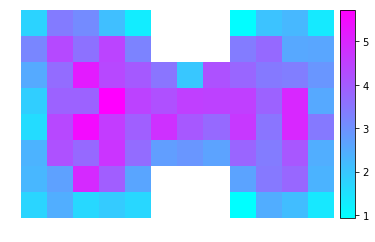

In [4]:
G.plot_indegrees()

In [5]:
betas = [80.,90.,100.,110.,120.]
# betas = [1, 1e-5, 0.]


In [6]:
mean_D_KLs = np.zeros((len(betas)))
for j in range(len(betas)):
    print "Beta " + str(j+1) + "/" + str(len(betas))
    RSP = HabitatAnalysis(G, \
                          beta = betas[j], \
                          similarity_measure='RSP_dissimilarity', \
                          affinity_to_cost='minus_log', \
                          distance_to_similarity='paper_choice', \
                          verbose=False)
    RSP.compute_similarities()
    
    D_KL = RSP.compute_KL_divergences_to()
    print D_KL[0:5, -5:-1]
    mean_D_KLs[j] = np.mean(D_KL[D_KL>0])
    
    # HFs2 = HFs*RSP.G.qualities


Beta 1/5
[[13.74158339 20.9275747  20.86472495 21.95954434]
 [15.20397542 18.75955967 18.69670663 19.791526  ]
 [13.85553906 17.41111957 17.34826653 18.4430859 ]
 [15.23334398 15.14921025 15.08635721 16.18117658]
 [13.39134907 14.75112615 14.68827311 15.78309248]]
Beta 2/5
[[13.74185809 20.92997645 20.87491315 21.96979383]
 [15.20410326 18.76096099 18.70589718 19.80077787]
 [13.85566369 17.41252086 17.35745706 18.45233774]
 [15.23357152 15.14937504 15.09431123 16.18919192]
 [13.39147367 14.75129093 14.69622713 15.79110781]]
Beta 3/5
[[13.74198417 20.93090529 20.87952349 21.97442487]
 [15.20415357 18.76154028 18.7101584  19.80505978]
 [13.85571352 17.41310016 17.36171828 18.45661966]
 [15.23364368 15.14944986 15.09806799 16.19296936]
 [13.39152351 14.75136576 14.69998388 15.79488526]]
Beta 4/5
[[13.74204268 20.93126401 20.88160476 21.97651304]
 [15.2041741  18.76177777 18.71211851 19.80702678]
 [13.85573399 17.41333764 17.36367838 18.45858665]
 [15.23366894 15.1494838  15.09982454 16.19

In [7]:
print mean_D_KLs

[10.19411091 10.25284392 10.29644515 10.32817994 10.35117543]


In [9]:
LC = HabitatAnalysis(G, \
                      similarity_measure='least_cost', \
                      compute_KL_divergences=True, \
                      affinity_to_cost='minus_log', \
                      distance_to_similarity='paper_choice', \
                      verbose=False)



LC.least_cost_distances_to()
D_KL_LC = LC.D_KL_LC
print D_KL_LC[0:5,0:5]
mean_D_KL_LC = np.mean(D_KL_LC[D_KL_LC>0])

print mean_D_KL_LC

[[0.         2.16954974 3.51798987 5.26722357 7.26783035]
 [2.84431145 0.         1.34844012 3.09767383 5.09828061]
 [4.09636864 1.2520572  0.         1.7492337  3.74984048]
 [5.47430488 2.62999344 1.37793624 0.         1.89772932]
 [6.96540601 4.12109457 2.86903737 1.38822367 0.        ]]
10.563050205179374


In [42]:
Q = np.matrix(LC.G.qualities).T

mean_D_KL = Q.T*D_KL_LC*Q
mean_D_KL = mean_D_KL[0,0]
mean_D_KL

73645.58603051059